<div style='background-image: url("./title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">The Pseudo-Spectral Method - Acoustic Waves in 1D</div>
        </div>
    </div>
</div>

This notebook covers the following aspects:
* Calculation of the second spatial derivative of the Pressure field using the Fourier transform
* Comparison with FD algorithms with 3- and 5-point operators

####Exercise:

* Change the frequency content of the source time function and observe the accuracies of the solutions
* **Advanced**: wrap a timer around the three solutions (inside the evolution scheme) and compare the wall clock time used in each method. Discuss!

## Basic Equations
We use the Fourier method to calculate exact n-th derivatives on a regular spaced grid (to machine precision). This property combined with classical time extrapolation schemes result in the so call Fourier pseudospectral method.  The problem of solving the 1D acoustic wave equation in an homogeneous media

\begin{equation}
\partial_t^2 p(x,t) = c(x)^2 \ \partial_x^2 p(x,t) + s(x,t)
\end{equation}

is covered in this notebook. We explore the benefits of calculating exact spatial derivatives (up to machine precision), numerical dispersion, comparison with a Finite Difference scheme

In [24]:
# Block 1: Setup, Imports, and Ricker Function Fetch

# Core Libraries
import numpy as np
import matplotlib.pyplot as plt
import requests
import importlib.util
import sys
import time

# Essential for Colab Plot Updates/Animation
from IPython import display
# Use the inline backend for manual updates
%matplotlib inline

# --- Fetch and import the Ricker wavelet function ---
# Your original code relies on this external file, we must fetch it.
url = "https://raw.githubusercontent.com/kboroz/ScientificMachineLearning/refs/heads/main/Week04%20/%20Pseudospectral%20Methods/Notebooks/ricker.py"
response = requests.get(url)

# Save temporarily
with open("ricker.py", "w") as f:
    f.write(response.text)

# Import it as a module
spec = importlib.util.spec_from_file_location("ricker", "ricker.py")
ricker_module = importlib.util.module_from_spec(spec)
sys.modules["ricker"] = ricker_module
spec.loader.exec_module(ricker_module)

# Now 'ricker' is available for use
ricker = ricker_module.ricker

print("Setup complete. Ricker function is ready.")

Setup complete. Ricker function is ready.


### 1. Fourier derivative method
The second spatial derivative is computed by multiplying the spatial Fourier transform of the pressure field $P(k,t)$ with $ (ik)^2 $

\begin{equation}
\partial_x^2 p(x,t) = \mathscr{F}^{-1}[(ik)^{2}P(k,t)] = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} (ik)^{2} P(k,t) e^{ikx} dk
\end{equation}

where $k$ is the wavenumber and $IFT$ the Inverse Fourier Transform. A function to perform this task is implemented in the next cell.

In [25]:
# Block 2: Derivative Function and Initialization

def fourier_derivative_2nd(f, dx):
    """
    Computes the second spatial derivative using the Fourier Pseudospectral method.
    """
    nx = np.size(f)
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))

    # Correctly set the wavenumber vector
    k[: int(nx/2)] = k[: int(nx/2)] * dk
    k[int(nx/2) :] = k[: int(nx/2)] - kmax

    # Fourier derivative: (ik)^2 * FFT(f)
    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num

# Basic parameters
nt    = 3500    # number of time steps
c     = 343.    # acoustic velocity [m/s]
eps   = 0.2     # stability limit
isnap = 50      # snapshot frequency
isx   = 1250    # source location
f0    = 60.     # Frequency [Hz]
nx    = 2024    # number of grid points in x

# Grid and time
dx = 1250./(nx-1)  # space increment
x  = np.arange(0, nx)*dx   # space coordinates
dt = eps*dx/c; # time step

# Array Initialization - USE .copy() TO AVOID OVERWRITING ARRAYS!
p = np.zeros(nx) ; pnew = p.copy() ; pold = p.copy() ; d2p = p.copy(); dp = p.copy()
ap = np.zeros(nx); apnew = ap.copy(); apold = ap.copy(); ad2p = ap.copy(); adp = ap.copy()
sp = np.zeros(nx); spnew = sp.copy(); spold = sp.copy(); sd2p = sp.copy(); sdp = p.copy()


# Source Initialization
t   = np.arange(1, nt+1)*dt  # time axis
T0  = 1./f0
tmp = ricker(dt, T0)
tmp = np.diff(tmp) # Derivative of Ricker (as per your original code)
src = np.zeros(nt)
src[0:np.size(tmp)] = tmp
lam = c*T0

# Spatial source function (Gaussian)
sigma = 2*dx
x0 = x[isx-1]
sg = np.exp(-1/sigma**2 *(x - x0)**2);
sg = sg/np.amax(sg)

print("Parameters, arrays, and source initialized.")

Parameters, arrays, and source initialized.


### 4. Time Extrapolation
The final solution for our 1D acoustic wave problem after introducing a finite differences time extrapolation schem can be written as

\begin{equation}
p_{j}^{n+1} = dt^2c_{j}^{2} \partial_{x}^{2}p_{j}^{n} + dt^2s_{j}^{n} + 2p_{j}^{n} - p_{j}^{n-1}
\end{equation}

where the space derivative is computed with the Fourier method. In order to compare the above numerical solution, we implement a 3-point finite difference operator, as well as a 5-point finite difference operator to compute spatial derivatives. They are given as:

1.) **3-point finite difference operator**
\begin{equation}
\partial_x^2 p(x,t) = \frac{p(x+\mathrm{d}x,t) - 2 p(x,t) + p(x-\mathrm{d}x,t)}{\mathrm{d}x^2}
\end{equation}

2.) **5-point finite difference operator**
\begin{equation}
\partial_x^2 p(x,t) = \frac{-p(x+2\mathrm{d}x,t) + 16p(x+\mathrm{d}x,t) - 30p(x,t) + 16p(x-\mathrm{d}x,t) - p(x-2\mathrm{d}x,t)}{12\mathrm{d}x^2}
\end{equation}

#### Numerical dispersion

One of the most prominent characteristic of the Fourier method is the low numerical dispersion in comparison with the finite difference method. The animation displayed below compare the effects of numerical dispersion on the solution of the 1D acoustic equation using our three different approaches.  

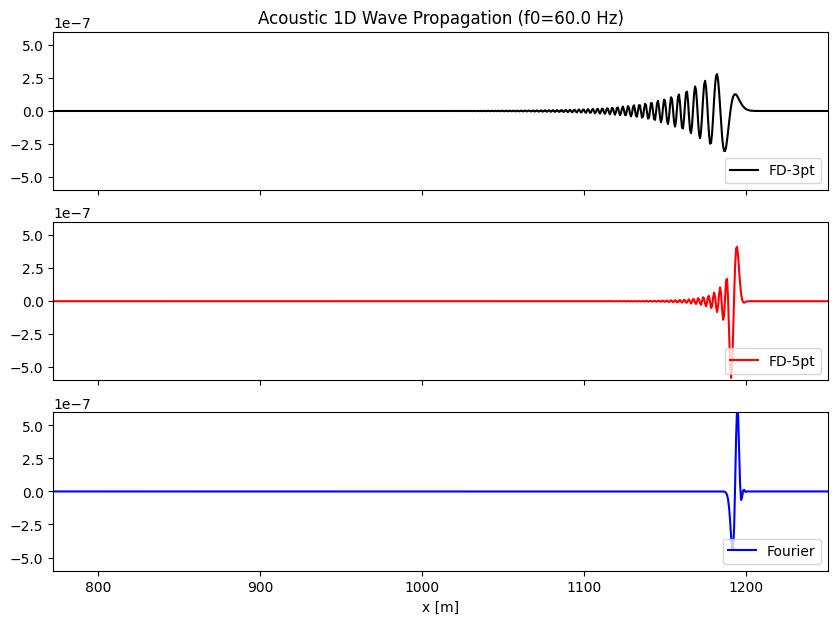

Simulation finished. Final plot displayed.


In [26]:
# Block 3: Time Extrapolation and Corrected Animation Loop

# ----------------------------------------------------------------
# Initialize animated plot - Store actual Line2D objects
# ---------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10,7))

# Store the actual Line2D object for each plot (using comma to unpack list)
line1, = ax1.plot(x[isx:], p[isx:], 'k', lw=1.5, label='FD-3pt')
line2, = ax2.plot(x[isx:], ap[isx:], 'r', lw=1.5, label='FD-5pt')
line3, = ax3.plot(x[isx:], sp[isx:], 'b', lw=1.5, label='Fourier')

# Set axes limits and labels
ax1.axis([isx*dx, nx*dx, -6E-7, 6E-7])
ax3.set_xlabel('x [m]')
ax1.set_title(f'Acoustic 1D Wave Propagation (f0={f0} Hz)')
ax1.legend(loc=4)
ax2.legend(loc=4)
ax3.legend(loc=4)

plt.show() # Show the initial plot

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
for it in range(nt):
    # --- Fourier Pseudospectral Method ---
    sd2p  = fourier_derivative_2nd(sp, dx)
    spnew = 2*sp - spold + c**2 * dt**2 * sd2p
    spnew = spnew + sg * src[it] * dt**2
    spold, sp = sp, spnew
    sp[0] = 0; sp[-1] = 0 # Boundary conditions (used -1 for nx-1)

    # --- Finite Differences Method 3pt ---
    for i in range(1, nx-1):
        d2p[i] = (p[i+1] - 2*p[i] + p[i-1]) / dx**2
    pnew = 2*p - pold + dt**2 * c**2 * d2p
    pnew = pnew + sg * src[it] * dt**2
    pold, p = p, pnew
    p[0] = 0; p[-1] = 0

    # --- Finite Differences Method 5pt ---
    for i in range(2, nx-2):
        ad2p[i] = (-1/12*ap[i+2] + 4/3*ap[i+1] - 5/2*ap[i]
                   + 4/3*ap[i-1] - 1/12*ap[i-2]) / dx**2
    apnew = 2*ap - apold + dt**2 * c**2 * ad2p
    apnew = apnew + sg * src[it] * dt**2
    apold, ap = ap, apnew
    ap[0] = 0; ap[-1] = 0

    # --------------------------------------
    # ANIMATION UPDATE (THE FIX)
    # --------------------------------------
    if not it % isnap:
        # 1. Update the data using set_ydata()
        line1.set_ydata(p[isx:])
        line2.set_ydata(ap[isx:])
        line3.set_ydata(sp[isx:])

        # 2. Force Colab to clear and redraw the figure
        display.clear_output(wait=True)
        display.display(fig)

        # 3. Pause briefly to control animation speed
        time.sleep(0.01)

# Final display of the figure after the loop completes
display.clear_output(wait=True)
display.display(fig)
print("Simulation finished. Final plot displayed.")